In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from heapq import nlargest
%matplotlib inline

In [4]:
data = pd.read_csv('reduced_var_data.csv', index_col = 0)
y = data['SalePrice']
x = data.drop(labels = 'SalePrice', axis=1)
data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtCond,BsmtExposure,...,GarageFinish,GarageCars,GarageArea,OpenPorchSF,MoSold,MSZoning_RL,Neighborhood_Crawfor,MasVnrArea_209.0,MasVnrArea_428.0,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,7.0,5.0,2003.0,2003.0,3.0,4.0,3.0,1.0,...,2.0,2.0,548.0,61.0,2.0,1.0,0.0,0.0,0.0,208500
2,80.0,9600.0,6.0,8.0,1976.0,1976.0,2.0,4.0,3.0,4.0,...,2.0,2.0,460.0,0.0,5.0,1.0,0.0,0.0,0.0,181500
3,68.0,11250.0,7.0,5.0,2001.0,2002.0,3.0,4.0,3.0,2.0,...,2.0,2.0,608.0,42.0,9.0,1.0,0.0,0.0,0.0,223500
4,60.0,9550.0,7.0,5.0,1915.0,1970.0,2.0,3.0,4.0,1.0,...,1.0,3.0,642.0,35.0,2.0,1.0,1.0,0.0,0.0,140000
5,84.0,14260.0,8.0,5.0,2000.0,2000.0,3.0,4.0,3.0,3.0,...,2.0,3.0,836.0,84.0,12.0,1.0,0.0,0.0,0.0,250000


In [5]:
def remove_outlier(data):
    threshold = 3
    mean_1 = np.mean(data)
    std_1 =np.std(data)
    
    index = []
    for indx, y in data.iteritems():
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) <= threshold:
            index.append(indx)
    return index

y = data['SalePrice']
x = data.drop(labels = 'SalePrice', axis=1).astype("float64")
x.shape, y.shape

((1459, 31), (1459,))

In [6]:
req_index = remove_outlier(y)
y = y[req_index]
x = x.loc[req_index]

In [7]:
x.shape, y.shape

((1437, 31), (1437,))

Now we removed the outliers from the dataset. The original data contains 1459 examples and the data without any outliers have 1437 examples. In other words, we removed 22 examples.

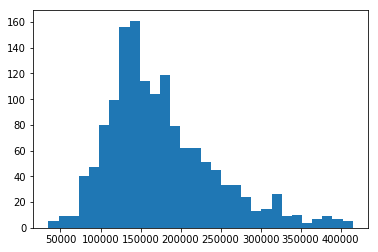

In [8]:
plt.hist(y, bins = 30);

## SVR on data without outliers

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [10]:
pipe = Pipeline(steps= [('ss', StandardScaler()), ('clf', SVR(gamma='scale'))])

param_grid = {
    'clf__C':[0.1, 0.5, 1.0, 1.5, 10,100, 150, 1000],
    'clf__kernel': ['linear', 'rbf', 'sigmoid', 'poly']
}

search = GridSearchCV(pipe, param_grid, cv=5, iid=False, scoring='neg_mean_absolute_error',
                      return_train_score=False)
search.fit(x, y)          # Here I am using the whole training data
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=-17566.177):
{'clf__C': 1000, 'clf__kernel': 'linear'}


In [11]:
best_svr = SVR(kernel='linear', gamma ='scale', C = 1000)
best_svr.fit(x_train, y_train)
y_pred = best_svr.predict(x_test)
print(mean_absolute_error(y_test, y_pred))

35803.7237557048


In [12]:
print(best_svr.score(x_test, y_test))

-0.9720676911859899


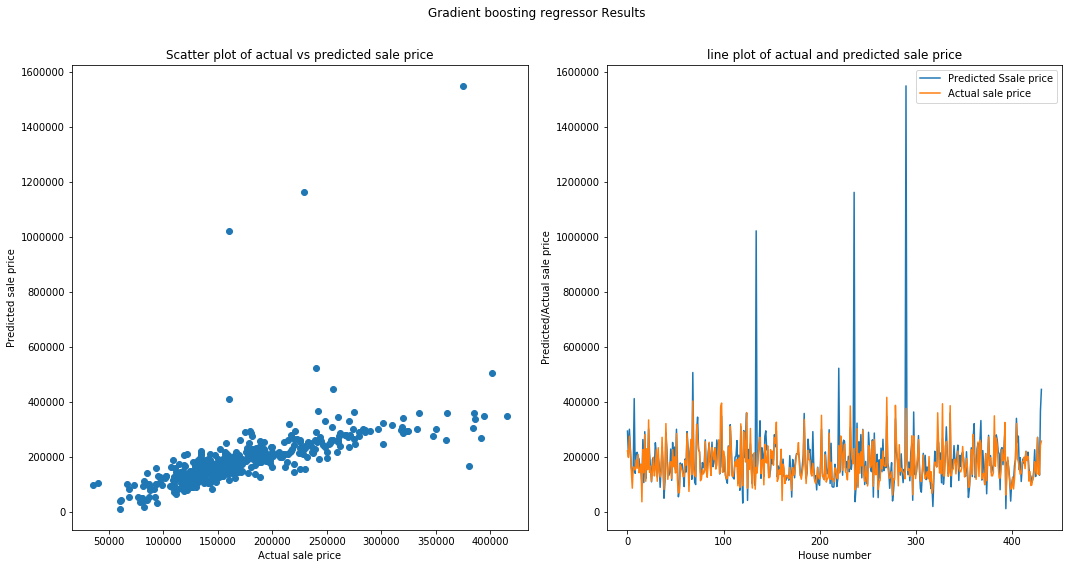

In [13]:
y_pred = best_svr.predict(x_test)
fig = plt.figure(figsize=(15,8))
fig.suptitle('Gradient boosting regressor Results')
plt.subplot(121)
plt.scatter(y_test.values, y_pred)
plt.xlabel('Actual sale price')
plt.ylabel('Predicted sale price')
plt.title('Scatter plot of actual vs predicted sale price')
plt.subplot(122)
plt.plot((y_pred), label='Predicted Ssale price')
plt.plot((y_test.values), label='Actual sale price')
plt.xlabel('House number')
plt.ylabel('Predicted/Actual sale price')
plt.title('line plot of actual and predicted sale price')
plt.legend()
plt.tight_layout()
fig.subplots_adjust(top=0.88)

In [14]:
print("Corrolation between true and predicted value using SVR on the actual sale price is {}".\
      format(np.corrcoef(y_test,y_pred)[0][1]))

Corrolation between true and predicted value using SVR on the actual sale price is 0.6088760705307661


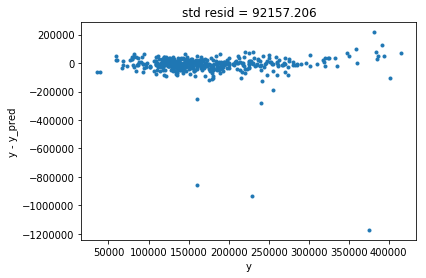

In [15]:
resid = y_test - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
plt.plot(y_test,y_test-y_pred,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('std resid = {:.3f}'.format(std_resid));

## Neural Networks 

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

ss = StandardScaler()
ss.fit(x_train)
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)

In [22]:
seed = 42
np.random.seed(seed)

n_feat = x.shape[1]
mdl = Sequential()
mdl.add(Dense(units=256, input_dim = n_feat, activation = 'relu'))
mdl.add(Dense(units=128, activation = 'relu'))
mdl.add(Dense(units=1, activation='linear'))

mdl.compile(loss='mean_squared_error', optimizer='adam', metrics= ['mse', 'mae'])
monitor = EarlyStopping(monitor= 'val_loss', min_delta=1e-3, 
                        patience = 10, verbose=1, mode = 'auto')
history = mdl.fit(x_train, y_train, validation_data = (x_test, y_test), 
                  callbacks=[monitor],batch_size= 64,epochs=5000,verbose=0)

y_pred = mdl.predict(x_test)
MSEscore = np.sqrt(mean_squared_error(y_pred, y_test))
print('Score RMSE = {}'.format(MSEscore))

MAEscore = np.sqrt(mean_absolute_error(y_pred, y_test))
print('Score RMAE = {}'.format(MAEscore))

mdl.summary()

Epoch 00455: early stopping
Score RMSE = 34589.7130836545
Score RMAE = 131.5287781117546
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               8192      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 41,217
Trainable params: 41,217
Non-trainable params: 0
_________________________________________________________________


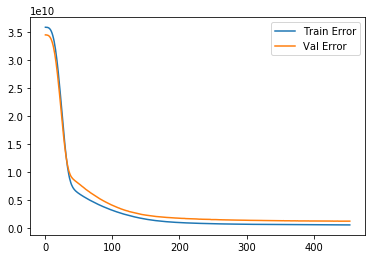

In [23]:
plt.figure()
plt.plot(history.epoch, history.history['mean_squared_error'], label = 'Train Error')
plt.plot(history.epoch, history.history['val_mean_squared_error'], label = 'Val Error')
plt.legend()

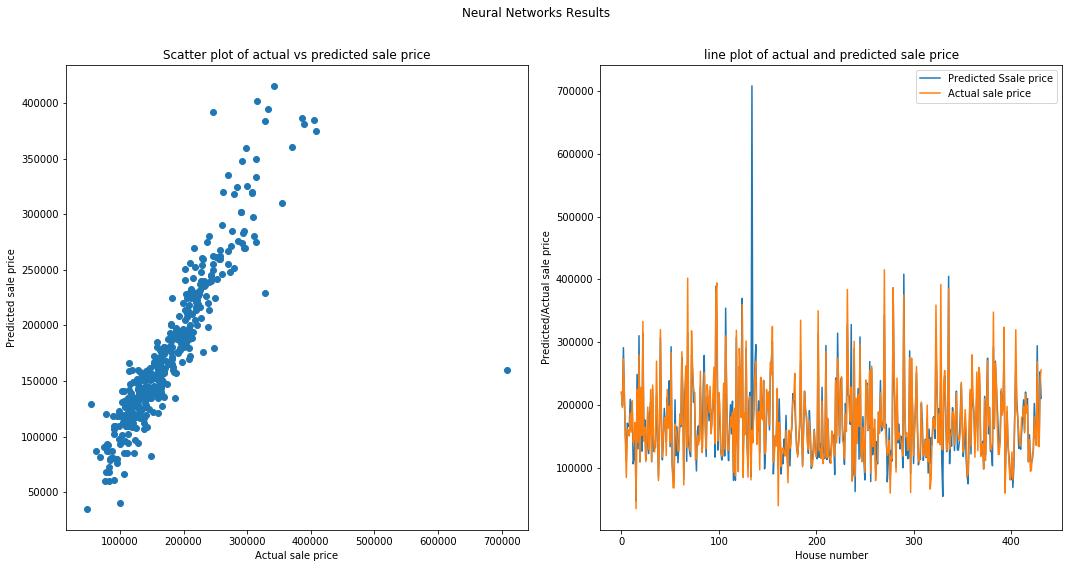

In [24]:
y_pred = mdl.predict(x_test)
fig = plt.figure(figsize=(15,8))
fig.suptitle('Neural Networks Results')
plt.subplot(121)
plt.scatter((y_pred), (y_test))
plt.xlabel('Actual sale price')
plt.ylabel('Predicted sale price')
plt.title('Scatter plot of actual vs predicted sale price')
plt.subplot(122)
plt.subplots_adjust(bottom=0.25)
plt.plot((y_pred), label='Predicted Ssale price')
plt.plot((y_test.values), label='Actual sale price')
plt.xlabel('House number')
plt.ylabel('Predicted/Actual sale price')
plt.title('line plot of actual and predicted sale price')
plt.legend()
plt.tight_layout()
fig.subplots_adjust(top=0.88)

In [25]:
print("Corrolation between true and predicted value using NN on the actual sale price is {}".\
      format(np.corrcoef(y_test,y_pred.squeeze())[0][1]))

Corrolation between true and predicted value using NN on the actual sale price is 0.8681737640579794


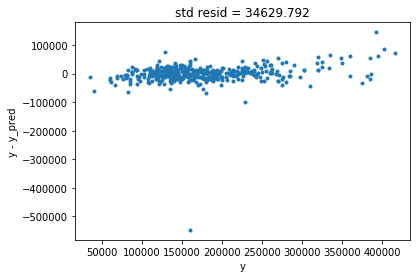

In [26]:
resid = y_test - y_pred.squeeze()
mean_resid = resid.mean()
std_resid = resid.std()
plt.plot(y_test,resid,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('std resid = {:.3f}'.format(std_resid));